In [1]:
# Importation des libraries de base. 

import pandas as pd
import os
import numpy as np
import dask.dataframe as dd 
import warnings 
warnings.filterwarnings("ignore")



In [2]:
# Fichier avec les variables d'intéret : dernière version : 13/02 

df_cct = pd.read_parquet("/home/onyxia/work/df_cct_final.parquet")

In [3]:
# Visualisation du fichier : 

df_cct.head()

User  Card  Month  Day day_of_week  Hours  Amount           Use Chip  \
0     0     0      9    1      Sunday      6  134.09  Swipe Transaction   
1     0     0      9    1      Sunday      6   38.48  Swipe Transaction   
2     0     0      9    2      Monday      6  120.34  Swipe Transaction   
3     0     0      9    2      Monday     17  128.95  Swipe Transaction   
4     0     0      9    3     Tuesday      6  104.71  Swipe Transaction   

         Merchant Name  Merchant City  ... Retired  daily_amount  \
0  3527213246127876953       La Verne  ...       0        134.09   
1  -727612092139916043  Monterey Park  ...       0        172.57   
2  -727612092139916043  Monterey Park  ...       0        120.34   
3  3414527459579106770  Monterey Park  ...       0        249.29   
4  5817218446178736267       La Verne  ...       0        104.71   

   nb_daily_declines_card  bad_pin  insufficient_balance  \
0                     0.0        0                     0   
1                     0.0        0                     0   
2                     0.0        0                     0   
3                     0.0        0                     0   
4                     0.0        0                     0   

   hr_nbt/last_30d_av_hr_nbt  last_18h_nbt  last_18h_amt  last_3d_amt/nbt  \
0                   1.000000           1.0        134.09       134.090000   
1                   1.333333           2.0        172.57        86.285000   
2                   0.750000           1.0        120.34        97.636667   
3                   0.800000           2.0        249.29       105.465000   
4                   0.833333           2.0        233.66       105.314000   

   Is Fraud?  
0          0  
1          0  
2          0  
3          0  
4          0  

[5 rows x 25 columns]

In [17]:
# Nom des colonnes : 

df_cct.columns

Index(['Month', 'Day', 'Hours', 'Amount', 'delta_t_s', 'delta_t_s_card',
       'amt/daily_income', 'Retired', 'daily_amount', 'nb_daily_declines_card',
       'bad_pin', 'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'last_3d_amt/nbt', 'Is Fraud?', 'Chip Transaction',
       'Online Transaction', 'Swipe Transaction', 'Merchant State_CA',
       'Merchant State_FL', 'Merchant State_IL', 'Merchant State_NC',
       'Merchant State_NY', 'Merchant State_OH', 'Merchant State_PA',
       'Merchant State_TX', 'Merchant State_None',
       'Merchant State_infrequent_sklearn', 'Merchant City_Brooklyn',
       'Merchant City_Chicago', 'Merchant City_Dallas',
       'Merchant City_Houston', 'Merchant City_Indianapolis',
       'Merchant City_Los Angeles', 'Merchant City_Miami',
       'Merchant City_ONLINE', 'Merchant City_Orlando',
       'Merchant City_infrequent_sklearn', 'Friday', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')

In [5]:
# Retirer les variables inutiles : trop corrélées aux autres : 'last_18h_nbt','last_18h_amt'
df_cct =  df_cct.drop(['last_18h_nbt','last_18h_amt'], axis = 1)

In [6]:


df_cct =  df_cct.drop(["Zip"], axis = 1) # inutile : information avec Merchant City (suffisamment précis).

# Drop "User" et "Merchant Name" : Discriment trop les transactions en fonctions des Users : on veut 
# une analyse sur les transactions.

df_cct =  df_cct.drop(["User", "Merchant Name"], axis = 1)

In [7]:
# Gérer les variables catégorielles pour DBSCAN. 
# Eviter le problème de hiérarchie entre les modalités : 
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html?fbclid=IwAR2eCoPI9skUHDegZeP31K--Psh2thHY_5anQPtngWD6qU3caG1UxFdwtR4
# On utilise One Encoder. 
# Package sklearn.preprocessing. 

In [8]:
from sklearn.preprocessing import OneHotEncoder

# Ex : On commence par les colonnes "Use Chip"     (A faire  "Merchant State", "Merchant City", 'day_of_week' )

# Pour "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)


In [9]:
# Pour "Merchant State" : 


enc = OneHotEncoder(handle_unknown='ignore',  max_categories=10)

features_array = enc.fit_transform(df_cct[["Merchant State"]]).toarray()

features_labels = np.array(enc.get_feature_names_out())

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)


In [10]:
# Pour "Merchant City" : 

enc = OneHotEncoder(handle_unknown='ignore',  max_categories=10)

features_array = enc.fit_transform(df_cct[["Merchant City"]]).toarray()

features_labels = np.hstack(np.array(enc.get_feature_names_out()))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)


In [11]:
# Pour 'day_of_week':

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[['day_of_week']]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [12]:
df_cct =  df_cct.drop(["Merchant State", "Merchant City", "Use Chip", 'day_of_week'], axis = 1)

# On retire également la variable "Card" : pas d'intérêt pour le clustering
# On souhaite étudier les types de transaction de manière générale. 
df_cct =  df_cct.drop(["Card" ], axis = 1)


In [13]:
# On ne centre réduit pas toutes les variables (perte d'information), on centre réduit unquement "timesstamp". 

#for i in range(len(df_cct.columns)):
    #mean = np.mean(df_cct[df_cct.columns[i]])
    #ec = np.std(df_cct[df_cct.columns[i]])
    #df_cct[df_cct.columns[i]] = (df_cct[df_cct.columns[i]]-mean)/ec

#mean = np.mean(df_cct[df_cct.columns["timestamp"]])
#ec = np.std(df_cct[df_cct.columns["timestamp"]])
#df_cct[df_cct.columns["timestamp"]] = (df_cct[df_cct.columns["timestamp"]]-mean)/ec


# Ici, on a pas besoin de centrer réduire les variables : 

df_cct.head()

Month  Day  Hours  Amount  delta_t_s  delta_t_s_card  amt/daily_income  \
0      9    1      6  134.09          0               0          0.819868   
1      9    1      6   38.48       1260            1260          0.235279   
2      9    2      6  120.34      85200           85200          0.735796   
3      9    2     17  128.95      40980           40980          0.788441   
4      9    3      6  104.71      45480           45480          0.640230   

   Retired  daily_amount  nb_daily_declines_card  ...  Merchant City_ONLINE  \
0        0        134.09                     0.0  ...                   0.0   
1        0        172.57                     0.0  ...                   0.0   
2        0        120.34                     0.0  ...                   0.0   
3        0        249.29                     0.0  ...                   0.0   
4        0        104.71                     0.0  ...                   0.0   

   Merchant City_Orlando  Merchant City_infrequent_sklearn  Friday  Monday  \
0                    0.0                               1.0     0.0     0.0   
1                    0.0                               1.0     0.0     0.0   
2                    0.0                               1.0     0.0     1.0   
3                    0.0                               1.0     0.0     1.0   
4                    0.0                               1.0     0.0     0.0   

   Saturday  Sunday  Thursday  Tuesday  Wednesday  
0       0.0     1.0       0.0      0.0        0.0  
1       0.0     1.0       0.0      0.0        0.0  
2       0.0     0.0       0.0      0.0        0.0  
3       0.0     0.0       0.0      0.0        0.0  
4       0.0     0.0       0.0      1.0        0.0  

[5 rows x 45 columns]

In [14]:
# Nom des colonnes : 

df_cct.columns

Index(['Month', 'Day', 'Hours', 'Amount', 'delta_t_s', 'delta_t_s_card',
       'amt/daily_income', 'Retired', 'daily_amount', 'nb_daily_declines_card',
       'bad_pin', 'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'last_3d_amt/nbt', 'Is Fraud?', 'Chip Transaction',
       'Online Transaction', 'Swipe Transaction', 'Merchant State_CA',
       'Merchant State_FL', 'Merchant State_IL', 'Merchant State_NC',
       'Merchant State_NY', 'Merchant State_OH', 'Merchant State_PA',
       'Merchant State_TX', 'Merchant State_None',
       'Merchant State_infrequent_sklearn', 'Merchant City_Brooklyn',
       'Merchant City_Chicago', 'Merchant City_Dallas',
       'Merchant City_Houston', 'Merchant City_Indianapolis',
       'Merchant City_Los Angeles', 'Merchant City_Miami',
       'Merchant City_ONLINE', 'Merchant City_Orlando',
       'Merchant City_infrequent_sklearn', 'Friday', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')

In [15]:
#Est ce que il y a des nan ? 
#print(df_cct.isna().all())

# Non, tout est ok

In [16]:
# Importation des libraries pour l'ACP et DBSCAN. 

import pandas.util.testing as tm
import seaborn as sns
from sklearn import cluster 
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from collections import Counter

In [50]:
# Problème de puissance de calcul on fait DBSCAN seulement sur 200 000 transactions tirées aléatoirement. 
# Sinon le Kernel meurt.... 
#df_cct = df_cct1
df_cct1 = df_cct.copy()
# Nouvelle idée : => surreprésenter les frauds pour pouvoir interpréter quelque chose. 
# On va prendre 5 % de fraud : 10000 sur l'échantillon de 200000 
# Fraud : 
df_cct_fraud = df_cct[df_cct['Is Fraud?'] == 1 ]
df_cct_non_fraud = df_cct[df_cct['Is Fraud?'] == 0 ]
#len(df_cct_fraud)
ech1 = df_cct_fraud.sample(10000)
ech2 = df_cct_non_fraud.sample(190000)
df_cct =  pd.concat([ech1, ech2], axis = 0)
df_cct = df_cct.sample(200000)
 



In [51]:
df_cct.head()

Month  Day  Hours  Amount  delta_t_s  delta_t_s_card  \
17529050      7   23      9  166.14       7740           63180   
6709072       1   16      6  160.00      54060           54060   
19076178      4   14     15  207.59       5820           23100   
22037107      8    5      5 -201.00      37140           72300   
19137373      6   14     11  -78.00     143100          143100   

          amt/daily_income  Retired  daily_amount  nb_daily_declines_card  \
17529050          0.855763        0        191.57                     0.0   
6709072           0.728579        0        160.00                     0.0   
19076178          1.968112        1        463.86                     0.0   
22037107         -1.462532        0        201.00                     0.0   
19137373         -0.703484        0         78.00                     0.0   

          ...  Merchant City_ONLINE  Merchant City_Orlando  \
17529050  ...                   0.0                    0.0   
6709072   ...                   0.0                    0.0   
19076178  ...                   1.0                    0.0   
22037107  ...                   1.0                    0.0   
19137373  ...                   0.0                    0.0   

          Merchant City_infrequent_sklearn  Friday  Monday  Saturday  Sunday  \
17529050                               1.0     0.0     0.0       0.0     0.0   
6709072                                1.0     0.0     0.0       0.0     1.0   
19076178                               0.0     0.0     0.0       0.0     0.0   
22037107                               0.0     0.0     0.0       0.0     1.0   
19137373                               1.0     0.0     0.0       0.0     0.0   

          Thursday  Tuesday  Wednesday  
17529050       0.0      1.0        0.0  
6709072        0.0      0.0        0.0  
19076178       0.0      1.0        0.0  
22037107       0.0      0.0        0.0  
19137373       0.0      0.0        1.0  

[5 rows x 45 columns]

In [53]:
len(df_cct)

# On a bien un échantillon aléatoire de 200 000 transactions. 

200000

In [21]:
# Implémentation de DBSCAN : 

# Questionnement ? Quelle distance utiliser ? Cosine ou euclidienne ? Test avec les deux. 

In [22]:
# Quelle distance utiliser avec DBSCAN ? Cosine vs euclidienne :
# The Euclidean distance corresponds to the L2-norm of a difference between vectors. 
# The cosine similarity is proportional to the dot product of two vectors and 
# inversely proportional to the product of their magnitudes. (angle)
# Vectors with a small Euclidean distance from one another are located in the same region 
# of a vector space. Vectors with a high cosine similarity 
# are located in the same general direction from the origin.
# Cosine : It is thus a judgment of orientation and not magnitude :  
# two vectors with the same orientation have a 
# cosine similarity of 1, two vectors oriented at 90° relative to each other have a 
# similarity of 0, and two vectors diametrically opposed have a similarity of -1, 
# independent of their magnitude.
# While cosine looks at the angle between vectors 
# (thus not taking into regard their weight or magnitude), 
# euclidean distance is similar to using a ruler to actually measure the distance.



In [54]:
# Dans notre cas : il semble que la distance euclidienne est tout de même plus intéressante pour 
# interpréter les résulats. 
# => Nous allons tout de même centrér réduire certaines variables : cad le temps : 
# 'delta_t_s', 'delta_t_s_card'

mean = np.mean(df_cct['delta_t_s'])
ec = np.std(df_cct['delta_t_s'])
df_cct['delta_t_s'] = (df_cct['delta_t_s']-mean)/ec

mean = np.mean(df_cct['delta_t_s_card'])
ec = np.std(df_cct['delta_t_s_card'])
df_cct['delta_t_s_card'] = (df_cct['delta_t_s_card']-mean)/ec


In [56]:
# Description des données : 

print(df_cct.describe())
print(df_cct["Is Fraud?"].describe())

# On garde une magnitude forte pour tout ce qui concerne les montants. 

# Bien 5 % de fraud. 

               Month            Day         Hours         Amount  \
count  200000.000000  200000.000000  200000.00000  200000.000000   
mean        6.521435      15.684800      12.36146      46.829295   
std         3.478139       8.793541       5.02521      92.256272   
min         1.000000       1.000000       0.00000    -500.000000   
25%         3.000000       8.000000       9.00000       9.380000   
50%         7.000000      16.000000      12.00000      31.230000   
75%        10.000000      23.000000      16.00000      68.000000   
max        12.000000      31.000000      23.00000    3416.640000   

          delta_t_s  delta_t_s_card  amt/daily_income        Retired  \
count  2.000000e+05    2.000000e+05     200000.000000  200000.000000   
mean   1.008971e-17   -5.209166e-18          8.642515       0.222955   
std    1.000003e+00    1.000003e+00        673.233497       0.416229   
min   -6.026203e-01   -1.224656e-01     -39055.000000       0.000000   
25%   -5.475665e-01   -1.12

In [57]:
X = df_cct.values
X.astype(np.float64)

array([[ 7., 23.,  9., ...,  0.,  1.,  0.],
       [ 1., 16.,  6., ...,  0.,  0.,  0.],
       [ 4., 14., 15., ...,  0.,  1.,  0.],
       ...,
       [12., 23., 10., ...,  0.,  0.,  0.],
       [ 1.,  1., 11., ...,  0.,  0.,  0.],
       [11.,  8.,  4., ...,  0.,  0.,  0.]])

In [26]:
# Maintenant que nous avons notre jeu de données nous allons chercher à déterminer le ε optimal
# pour obtenir un meilleur partitionnement de notre jeu de données. 
# On veut que 90 à 95 % des observations aient au moins 4 voisins dans leur epsilon-voisinage. 
# On veut éviter un trop grand nombre d'outliers. 
# On part sur un min_sample à 5. 

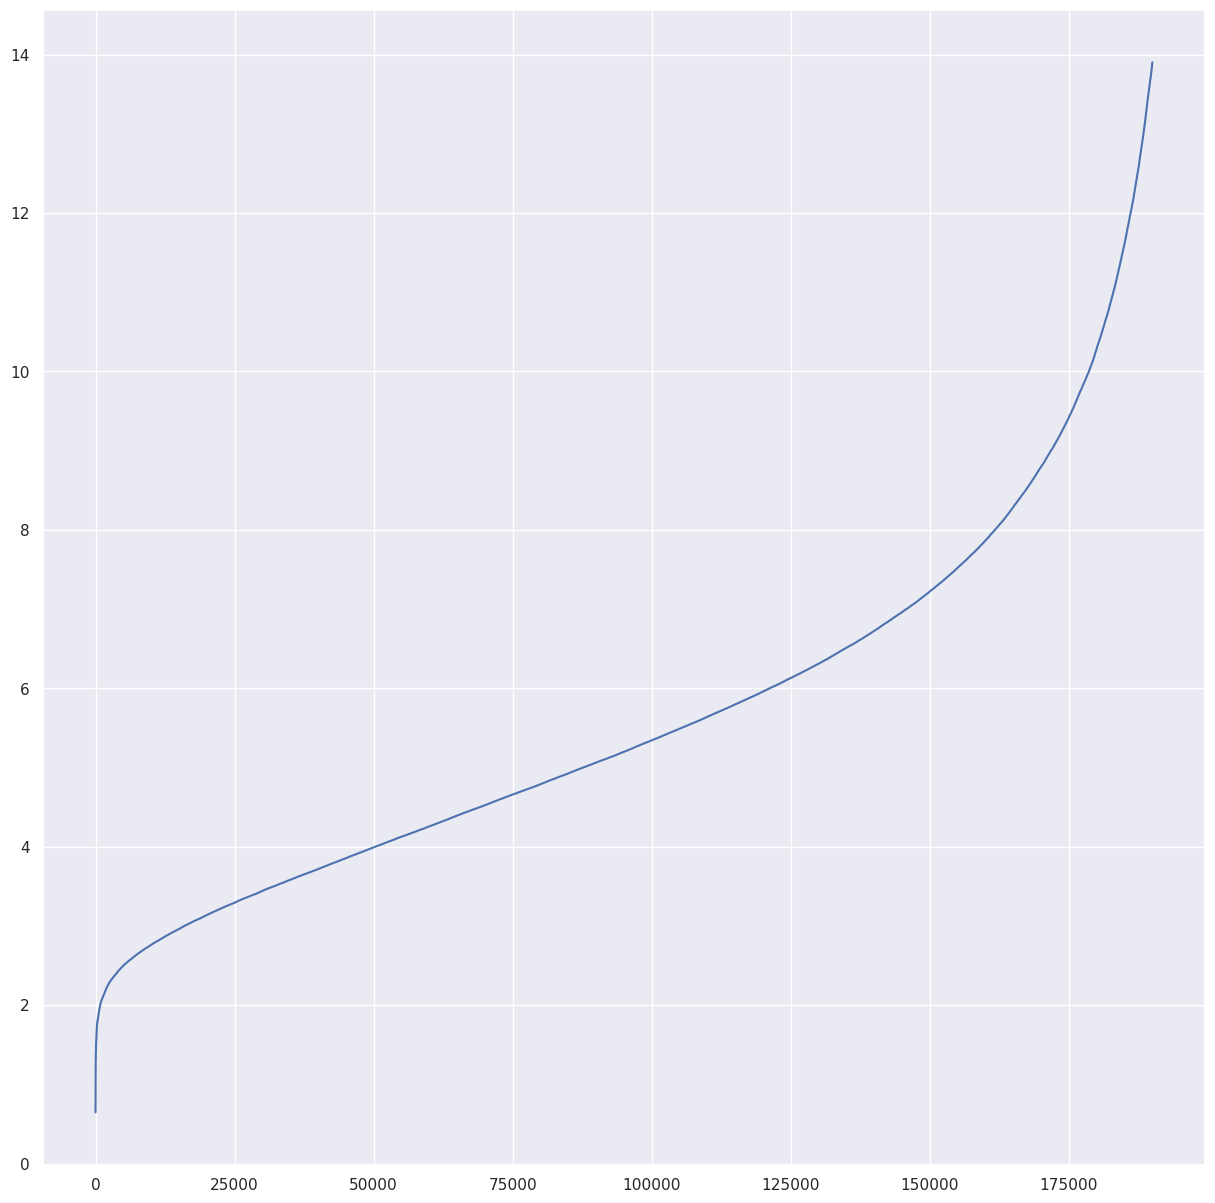

In [80]:
#Scikit-Learn met à disposition une classe NearestNeighbors qui permet de déterminer 
# les voisins les plus proches de chaque observation ainsi que les distances. 

%matplotlib inline
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:190000,1]
plt.plot(distances);

# Conclusion : prendre eps = 9,10,11,12 de tel sorte que au moins 95 % des observations appartiennent à un 
# groupe pour un min_sample = 5. 

# On veut au moins que 90 % des 200 000 transactions soient dans un cluster. 

# => But de ce bout de code : éviter d'avoir trop d'outliers : donne le nombre 
# de points qui sont dans un cluster. 

In [41]:
# Choix de eps et min_samples :

# Choix de eps : 

# Aurre possibilité pour choisir eps : 

#Eps=np.linspace(1,2.5,num=10)
#N=[]
#L=[]
#for eps in Eps:
  #clustering =  cluster.DBSCAN(eps=eps, min_samples=5)
  #clustering.fit(X)
  #labels = clustering.labels_
  #L.append(labels)
  #n=np.unique(labels)
  #N+=[len(n)]

#sns.lineplot(x=Eps,y=N)


# Nbr d'outliers : 

#for s in L:
    #d = Counter(s)
    #for i in d:
        #print(i, d[i])

<AxesSubplot: >

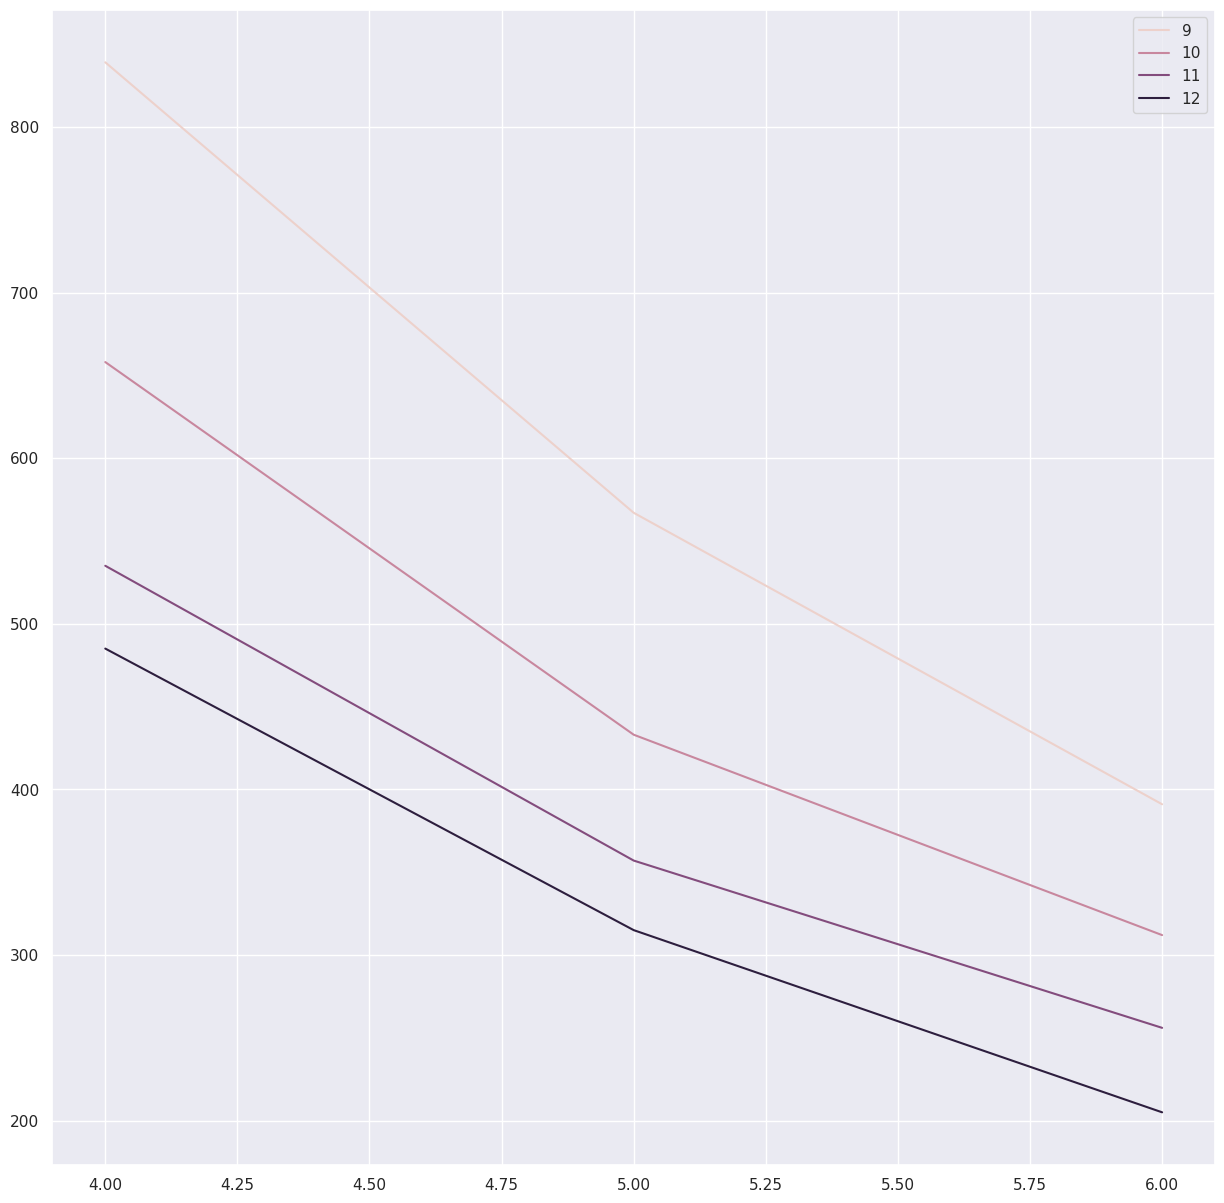

In [67]:
 # Choix de min_samples : On test des eps autour de 9,10,11,12 avec des min_sample = 4 ou 5 ou 6. 

Eps = [9,10,11,12]
Sample = [4,5,6]
N=[]

x = []
hue = []

for sample in Sample:
  for eps in Eps:
    clustering=cluster.DBSCAN(eps, min_samples=sample, n_jobs = -1)
    clustering.fit(X)
    labels=clustering.labels_
    n=np.unique(labels)
    N+=[len(n)]

    x.append(eps) 
    hue.append(sample)

sns.lineplot(x= hue,y=N, hue = x)

# On affiche le nombre de groupe crée : 

In [68]:
# Choix intéressant pour eps et min_samples :  11 et 5

clustering=cluster.DBSCAN(eps=11, min_samples=5, n_jobs = -1)
clustering.fit(X)
len(np.unique(clustering.labels_))

# Nombre de groupes : 

357

In [69]:
labels = clustering.labels_
d = Counter(labels)
d[-1]


# Nombre d'outliers pour ce choix de eps et min_sample : 
# Environ 10 %  

25901

In [70]:
# ACP : réduction de dimension => représenter la méthode DBSCAN (nuage de points)
# On utilise les 2 dimensions les plus représentatives du sample (dim 1 et dim 2, les dimensions 
# avec les valeurs propres les plus grandes.) 

pca = PCA()
pca.fit(df_cct)
df_cct.columns = df_cct.columns.astype("str")
df_cct_pca = pca.transform(df_cct)
df_cct_pca_df = pd.DataFrame({
    "Dim1" : df_cct_pca[:,0], 
    "Dim2" : df_cct_pca[:,1]})
df_cct_pca_df["labels"] = clustering.labels_

In [71]:
# Faire apparaître les valeurs propres sur l'ACP.  => Interpréter / comprendre les axes + représentatifs ? 


eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(len(pca.explained_variance_))], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
eig


Dimension  Variance expliquée  % variance expliquée  % cum. var. expliquée
0       Dim1        4.532498e+05                  89.0                   89.0
1       Dim2        4.785428e+04                   9.0                   98.0
2       Dim3        7.514520e+03                   1.0                  100.0
3       Dim4        1.553161e+03                   0.0                  100.0
4       Dim5        7.732774e+01                   0.0                  100.0
5       Dim6        2.315856e+01                   0.0                  100.0
6       Dim7        1.209403e+01                   0.0                  100.0
7       Dim8        1.062283e+00                   0.0                  100.0
8       Dim9        8.751997e-01                   0.0                  100.0
9      Dim10        6.007327e-01                   0.0                  100.0
10     Dim11        3.481123e-01                   0.0                  100.0
11     Dim12        2.291598e-01                   0.0                  100.0
12     Dim13        1.797397e-01                   0.0                  100.0
13     Dim14        1.733859e-01                   0.0                  100.0
14     Dim15        1.453372e-01                   0.0                  100.0
15     Dim16        1.444961e-01                   0.0                  100.0
16     Dim17        1.434277e-01                   0.0                  100.0
17     Dim18        1.420948e-01                   0.0                  100.0
18     Dim19        1.415742e-01                   0.0                  100.0
19     Dim20        1.400458e-01                   0.0                  100.0
20     Dim21        8.961844e-02                   0.0                  100.0
21     Dim22        6.741754e-02                   0.0                  100.0
22     Dim23        5.903710e-02                   0.0                  100.0
23     Dim24        5.026740e-02                   0.0                  100.0
24     Dim25        4.933826e-02                   0.0                  100.0
25     Dim26        3.985395e-02                   0.0                  100.0
26     Dim27        3.707875e-02                   0.0                  100.0
27     Dim28        3.485726e-02                   0.0                  100.0
28     Dim29        3.213973e-02                   0.0                  100.0
29     Dim30        3.008005e-02                   0.0                  100.0
30     Dim31        7.956502e-03                   0.0                  100.0
31     Dim32        7.351140e-03                   0.0                  100.0
32     Dim33        6.400617e-03                   0.0                  100.0
33     Dim34        6.003785e-03                   0.0                  100.0
34     Dim35        5.223088e-03                   0.0                  100.0
35     Dim36        4.656080e-03                   0.0                  100.0
36     Dim37        4.425411e-03                   0.0                  100.0
37     Dim38        4.176189e-03                   0.0                  100.0
38     Dim39        2.535715e-03                   0.0                  100.0
39     Dim40        2.938963e-04                   0.0                  100.0
40     Dim41        2.520395e-27                   0.0                  100.0
41     Dim42        2.520395e-27                   0.0                  100.0
42     Dim43        2.520395e-27                   0.0                  100.0
43     Dim44        2.520395e-27                   0.0                  100.0
44     Dim45        2.520395e-27                   0.0                  100.0

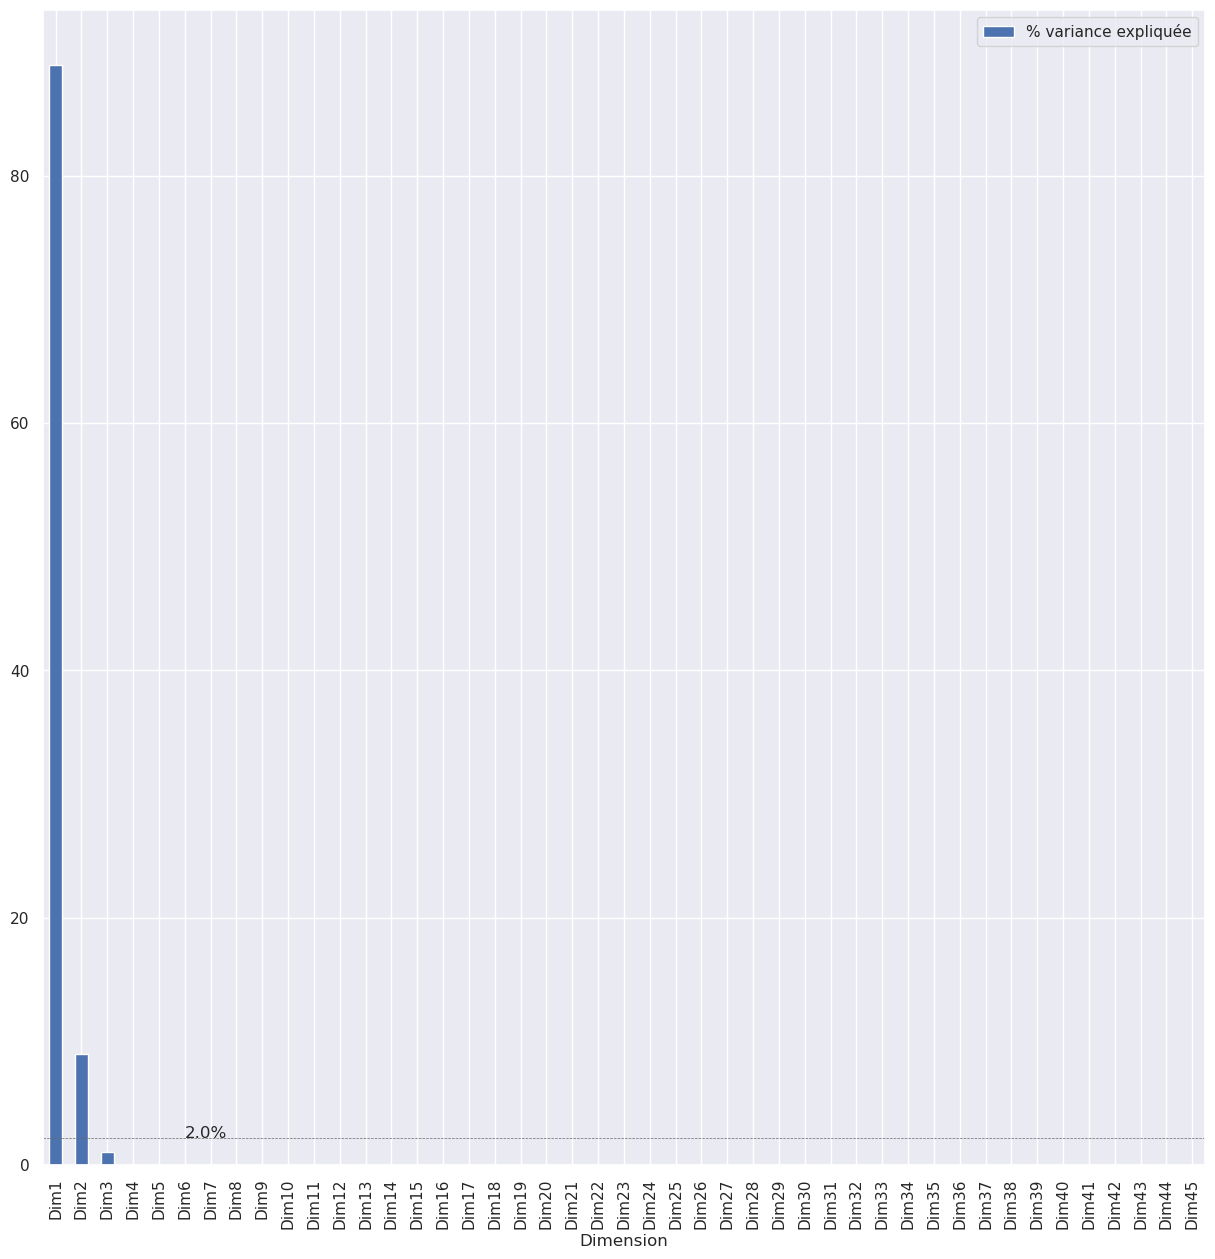

In [72]:
import matplotlib.pyplot as plt

eig.plot.bar(x = "Dimension", y = "% variance expliquée") # permet un diagramme en barres
plt.text(5, 100/(len(pca.explained_variance_)+1), str(np.round(100/(len(pca.explained_variance_)+1)))+"%") # ajout de texte
plt.axhline(y = (100/(len(pca.explained_variance_)+1)), linewidth = .5, color = "dimgray", linestyle = "--") # (100/(len(pca.explained_variance_)+1)) (nb dimensions)
plt.show()


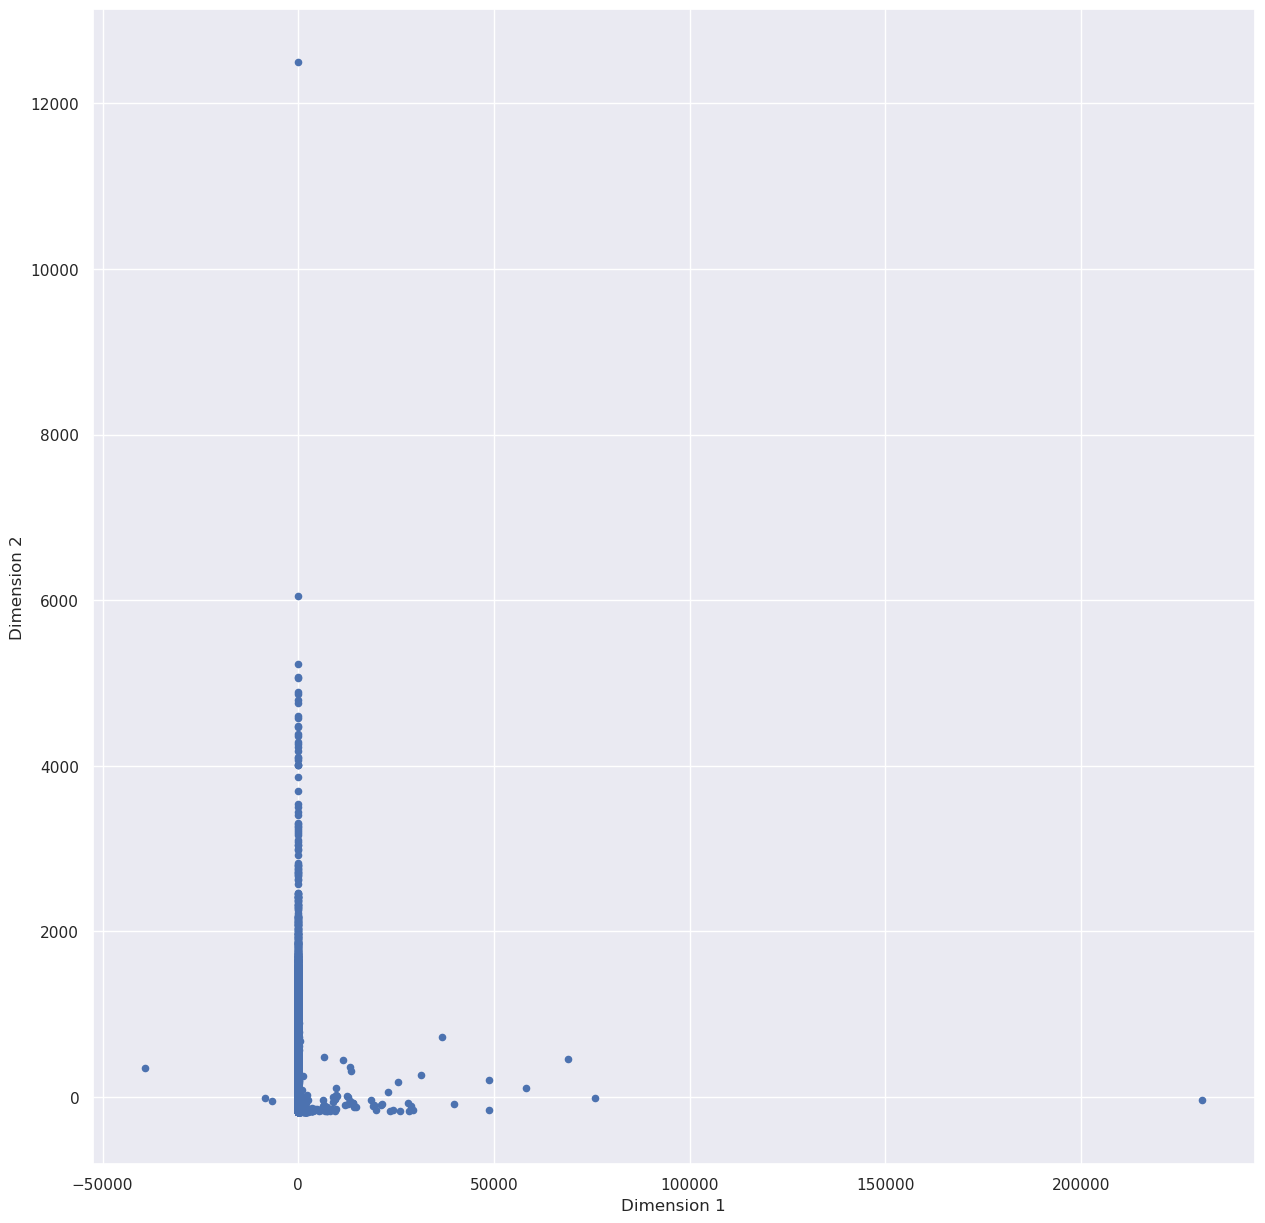

In [73]:
# Représentation de l'ACP :

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
df_cct_pca_df.plot.scatter("Dim1", "Dim2", ax = ax)

# boucle sur chaque pays
# for k in df_cct_pca_df.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    # if (abs(k[1]['Dim1']) > 5) & (abs(k[1]['Dim2']) > 5):
        # ax.annotate(k[1]["Amount"], (k[1]['Dim1'], k[1]['Dim2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()

<AxesSubplot: xlabel='Dim1', ylabel='Dim2'>

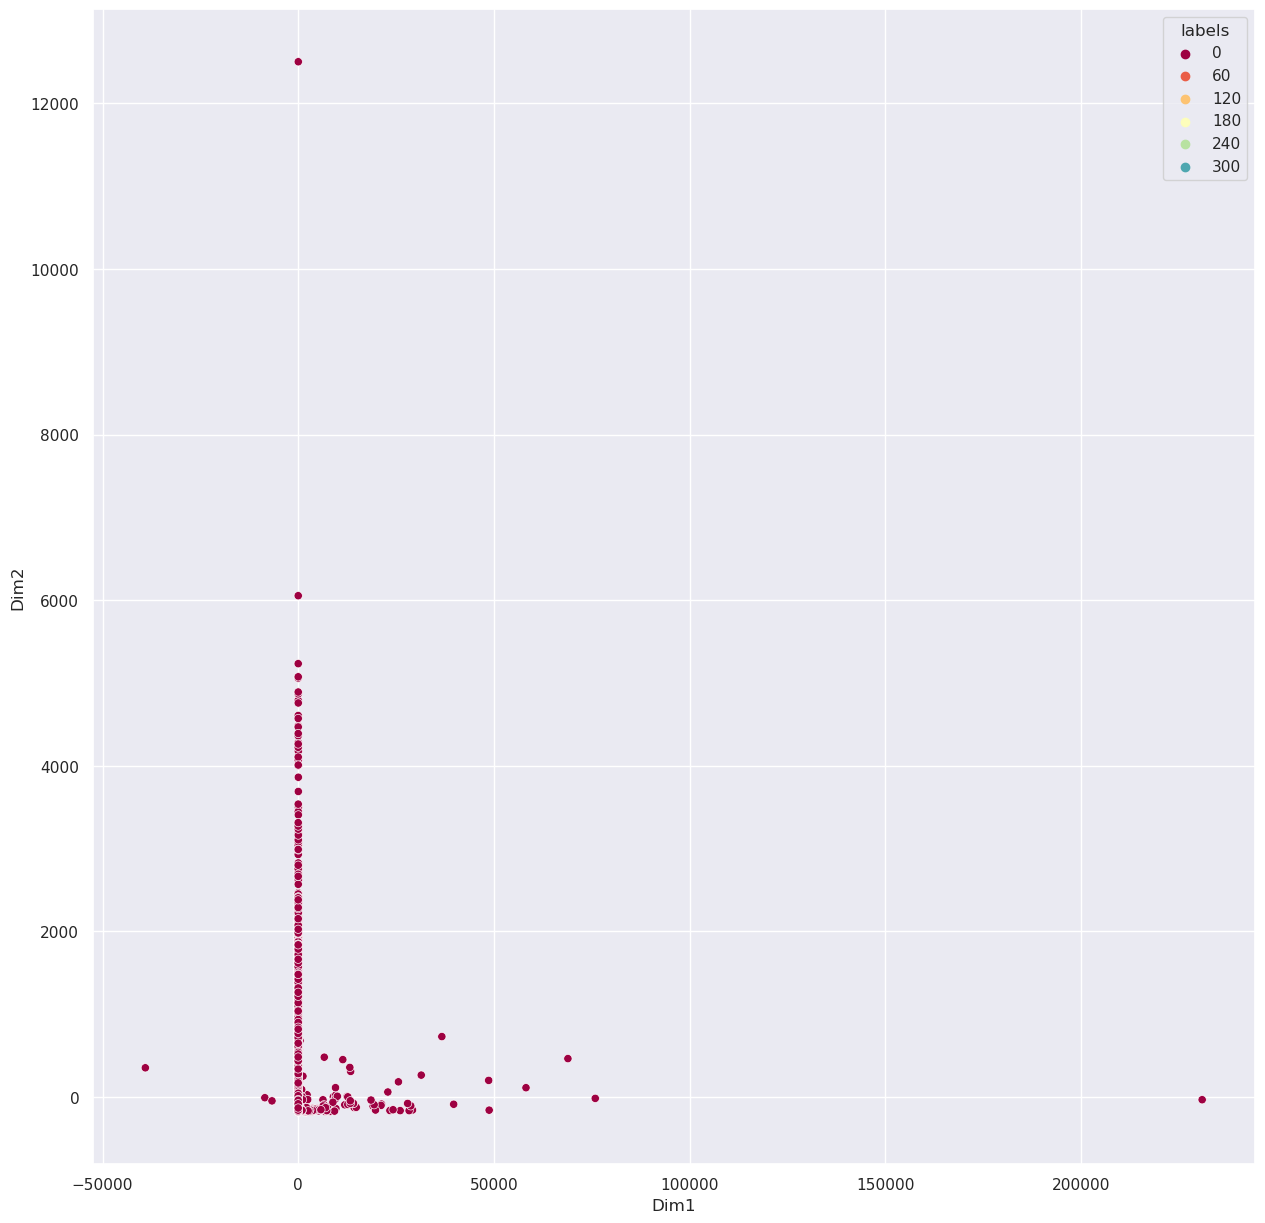

In [74]:
# Représentation de DBSCAN avec l'ACP : 
sns.set(rc = {'figure.figsize':(15,15)})
sns.scatterplot(data = df_cct_pca_df, x = "Dim1", y = "Dim2", hue = df_cct_pca_df["labels"], palette="Spectral")

In [31]:
#!!!!!!!!!!!!!!!!!!!
# ACP en cascade :........................
#- ACP en cascade : sélectionner 10 familles de variables, faire une ACP sur chaque famille, 
# récupérer les axes, faire une 2e ACP sur toutes les ACP (pour enlever le problème des variables catégorielles)
# Sparse ACP ?
#!!!!!!!!!!!!!!!!!!!

In [38]:
#!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.3 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82813 sha256=7baa338115d8e8898edd7684de786e925d25e6cbae8c171bf932b103572900c3
  Stored in directory: /home/onyxia/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55496 sha256=4e8e8bf9aaef2a09e3fa68b3498eeb0d7c4a797b691de8858d0f7ada740d2cca
  Stored in directory: /home/onyxia/.cache/pip/wheels/f8/5c/b4/a06301605095861524c1c7268a0d445b3a4c50292ce3bec24c
Successfully built umap-learn pynndescent


In [39]:
# Un simple !pip install umap et import umap ne fonctionne pas... 
import umap.umap_ as umap

In [75]:
# UMAP : autre méthode de réduction de dimension :

reducer = umap.UMAP()
reduced_X = reducer.fit_transform(df_cct.values)

In [76]:
reduced_df = pd.DataFrame(reduced_X, columns = ["A1", "A2"])
reduced_df["Label"] = clustering.labels_

<AxesSubplot: xlabel='A1', ylabel='A2'>

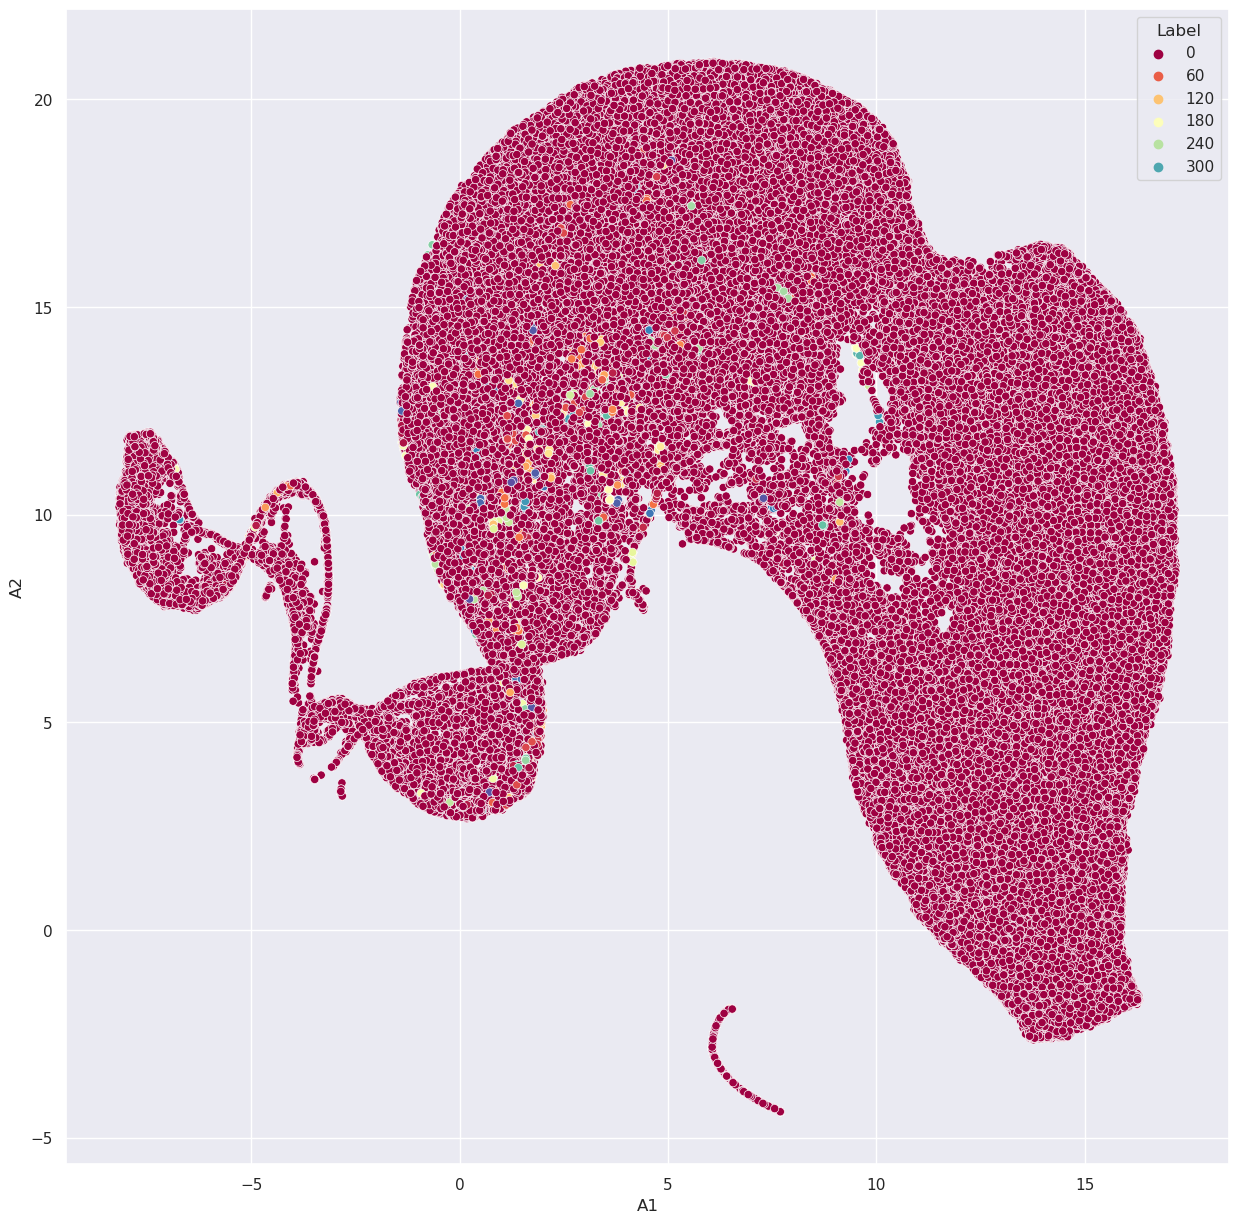

In [77]:
# Représentation de DBSCAN avec UMAP : 

sns.set(rc = {'figure.figsize':(15,15)})
sns.scatterplot(data = reduced_df, x = "A1", y = "A2", hue = "Label", palette="Spectral")

In [38]:
# Interprétation des résultats : On commence par le DBSCAN / umap : 

# 1 Trouver les points correspondant à des frands : 

# Idée : essayer d'identifier les types de transaction reliés à chaque clusters. 

# Quelle valeur correspond à une transaction en ligne ? 

df_cct["Online Transaction"].unique()

# Valeur :  2.82633622
val = df_cct["Online Transaction"].unique()[1]

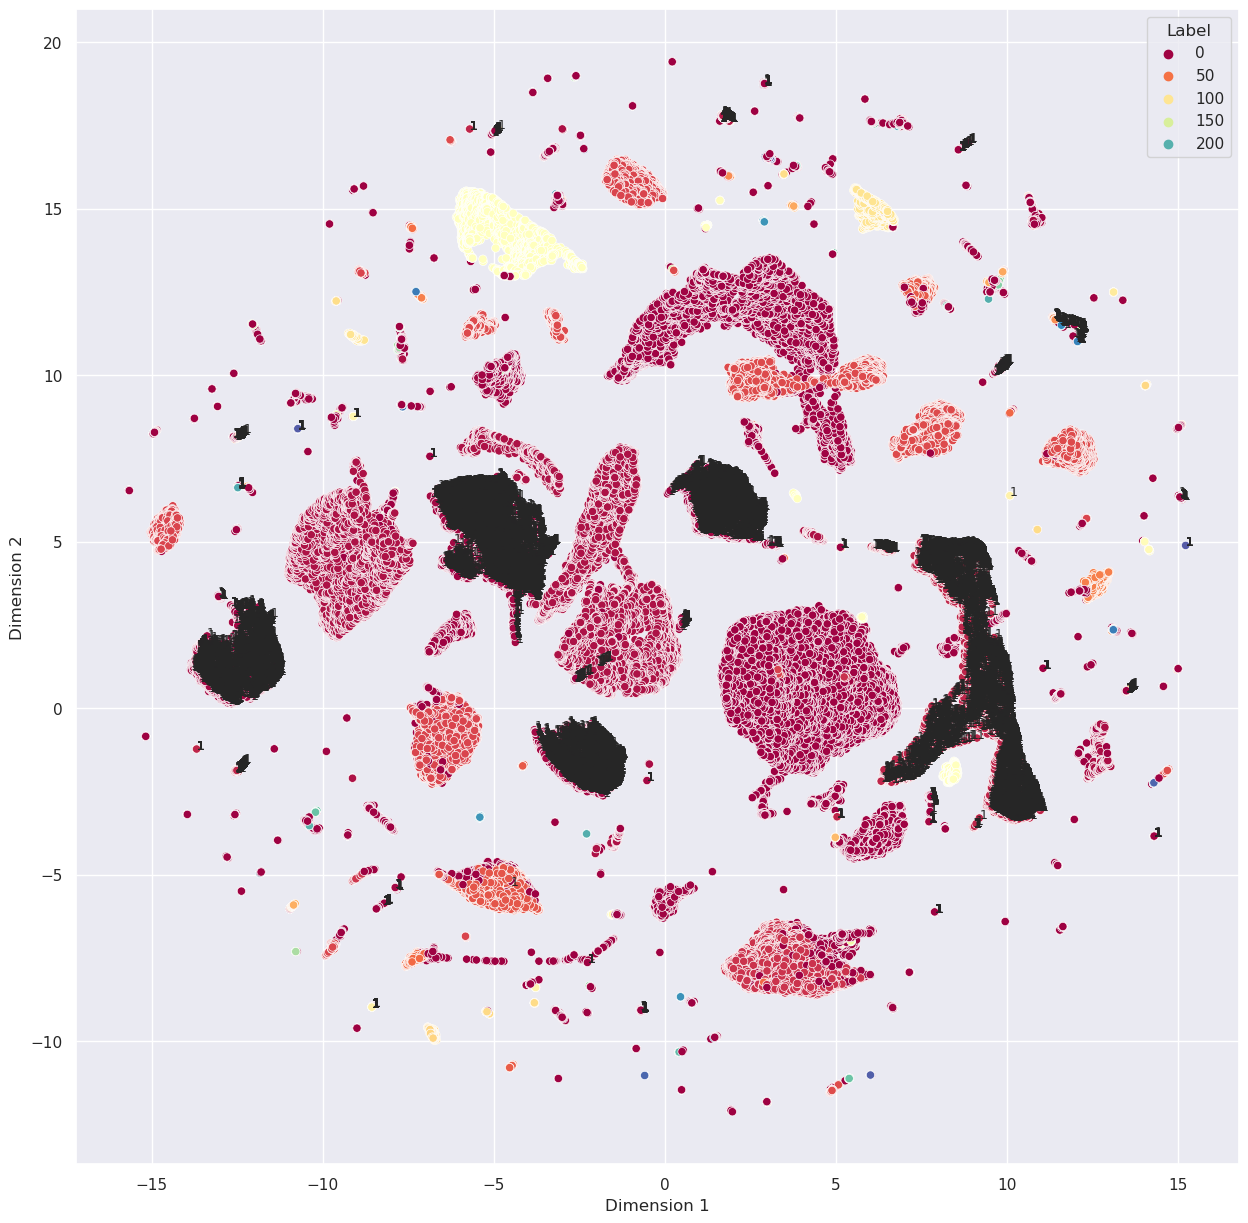

In [39]:
reduced_dfbis = pd.concat([reduced_df, df_cct["Online Transaction"]], axis = 1)


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data = reduced_dfbis, x = "A1", y = "A2", hue = "Label", palette="Spectral")

# boucle sur chaque pays
for k in reduced_dfbis.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    if (k[1]['Online Transaction'] == val) :
        ax.annotate("1", (k[1]['A1'], k[1]['A2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()


# Intéressant : clairement les transactions en ligne ont été rassemblées dans certains paquets.


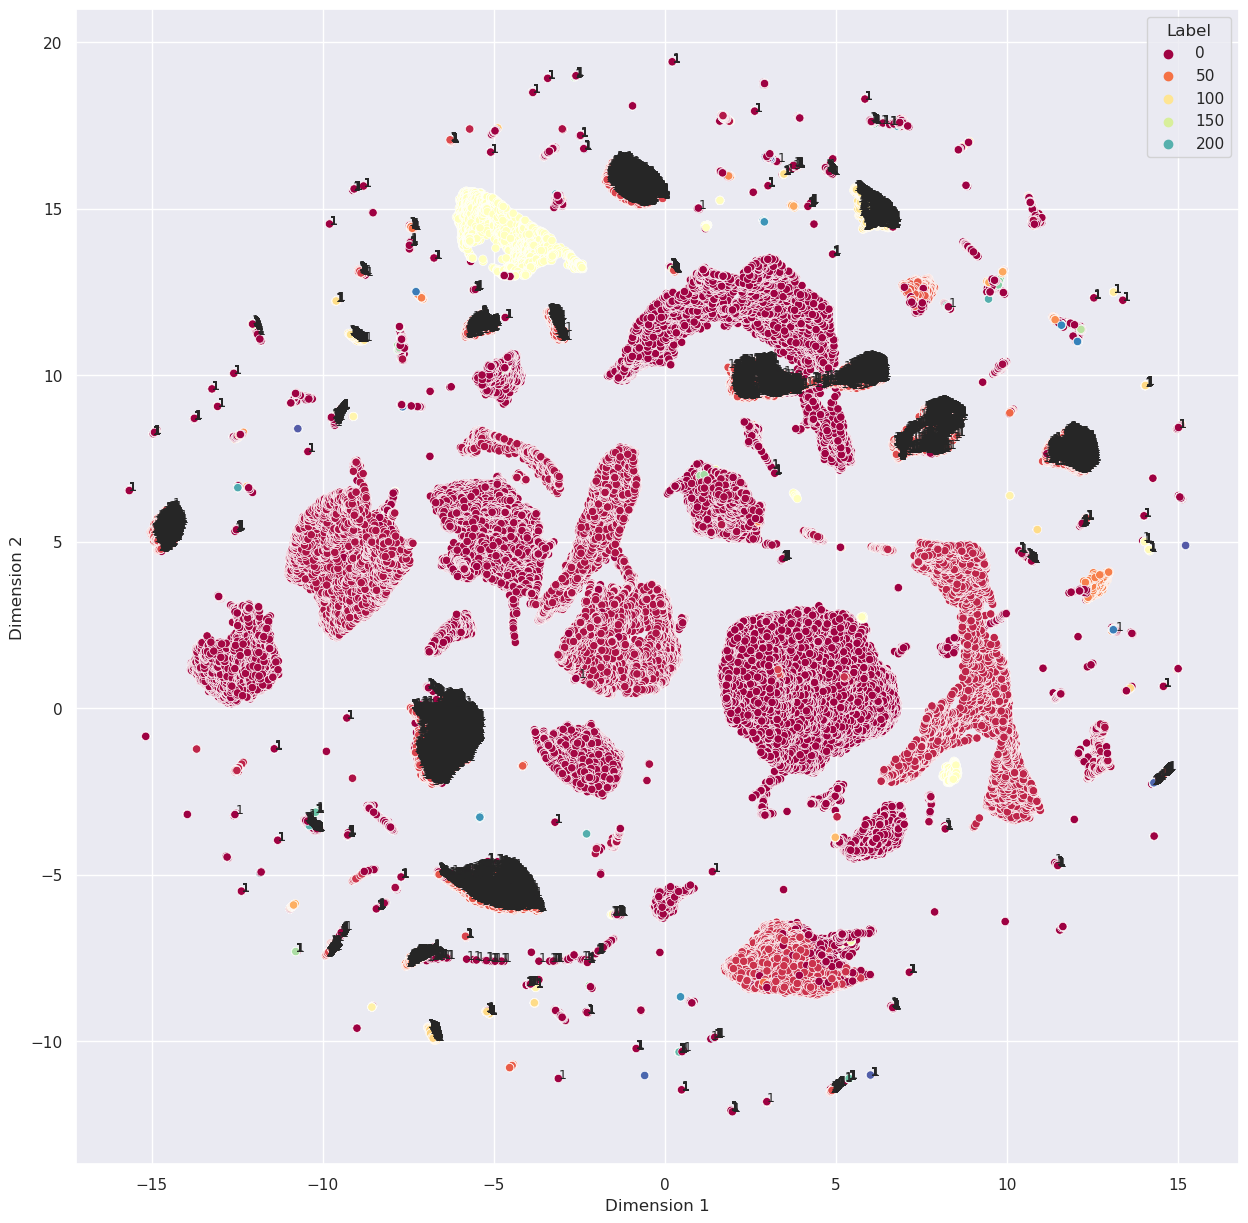

In [40]:
# Essayons pour les autres types de transaction : 

reduced_dfbis = pd.concat([reduced_df, df_cct["Chip Transaction"]], axis = 1)

val = df_cct["Chip Transaction"].unique()[1]

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data = reduced_dfbis, x = "A1", y = "A2", hue = "Label", palette="Spectral")

# boucle sur chaque pays
for k in reduced_dfbis.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    if (k[1]["Chip Transaction"] == val) :
        ax.annotate("1", (k[1]['A1'], k[1]['A2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()

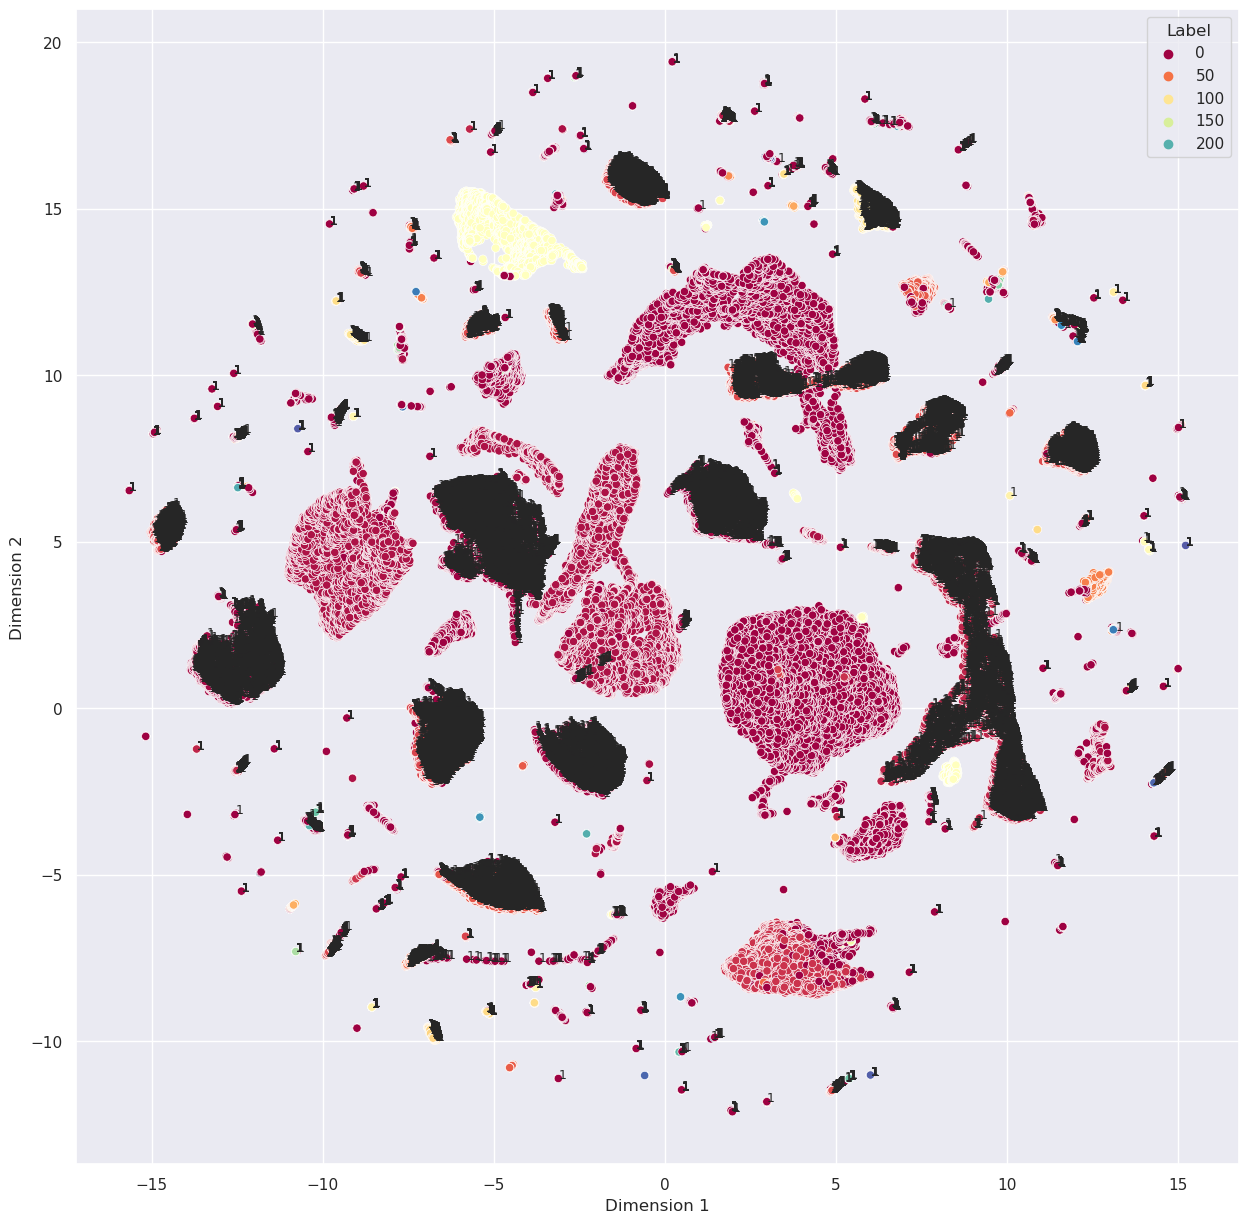

In [41]:
reduced_dfbis = pd.concat([reduced_df, df_cct["Swipe Transaction"]], axis = 1)

val = df_cct["Swipe Transaction"].unique()[1]

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data = reduced_dfbis, x = "A1", y = "A2", hue = "Label", palette="Spectral")

# boucle sur chaque pays
for k in reduced_dfbis.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    if (k[1]["Swipe Transaction"] == val) :
        ax.annotate("1", (k[1]['A1'], k[1]['A2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()

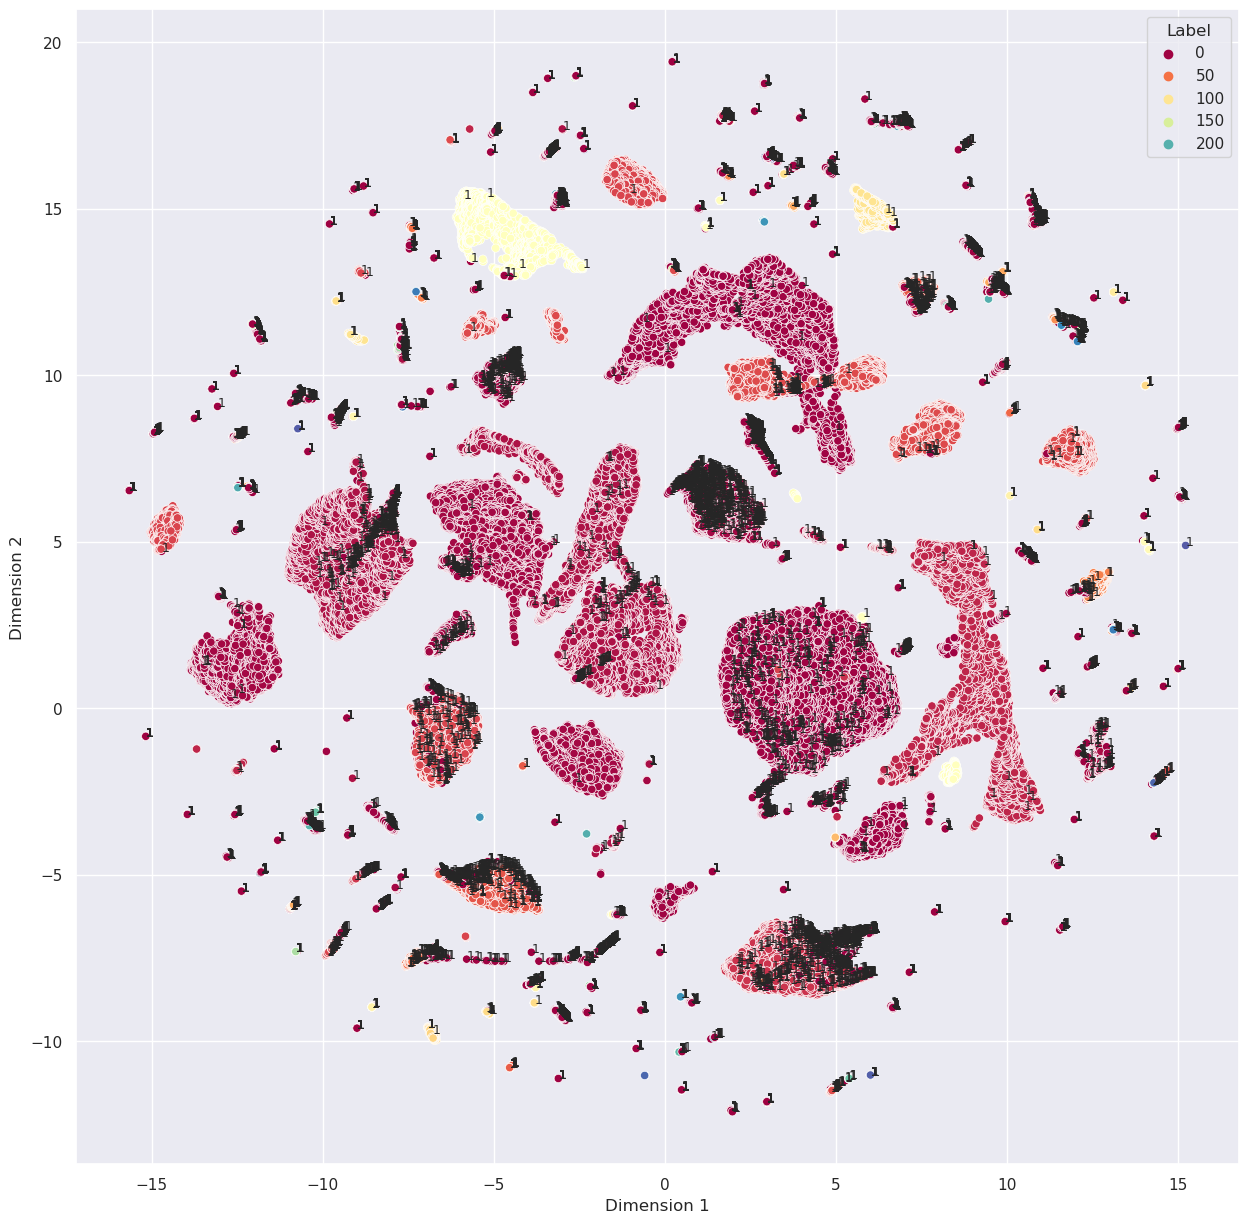

In [42]:
# Trouver les outliers : 

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data = reduced_dfbis, x = "A1", y = "A2", hue = "Label", palette="Spectral")

for k in reduced_dfbis.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    if (k[1]["Label"] == -1) :
        ax.annotate("1", (k[1]['A1'], k[1]['A2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()


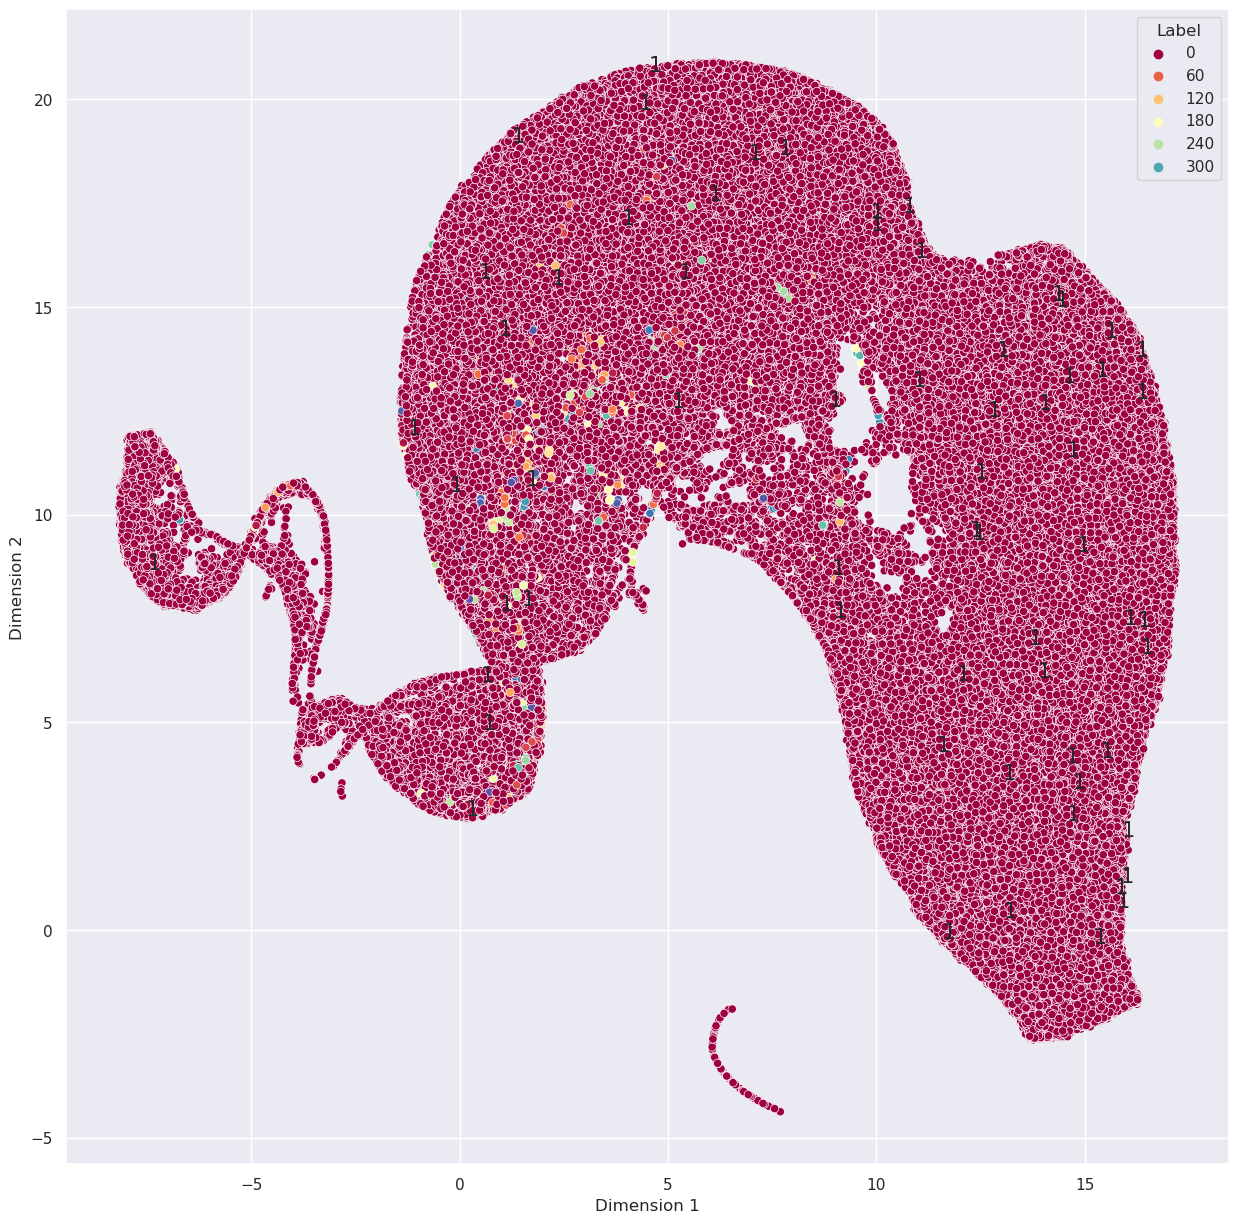

In [78]:
# Trouver les frauds : 
reduced_dfbis = pd.concat([reduced_df, df_cct["Is Fraud?"]], axis = 1)

val = df_cct["Is Fraud?"].unique()[1]

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data = reduced_dfbis, x = "A1", y = "A2", hue = "Label", palette="Spectral")

# boucle sur chaque pays
for k in reduced_dfbis.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    if (k[1]["Is Fraud?"] == val) :
        ax.annotate("1", (k[1]['A1'], k[1]['A2']), fontsize = 15)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()

In [44]:
# Rappel : nbr de Fraud dans le dataset : 
len(df_cct1[df_cct1["Is Fraud?"]== df_cct["Is Fraud?"].unique()[1]]) # => 29,757 frauds out of 24,386,900 transactions

29757

In [45]:
# nbr de Fraud sur les 150 000 premières lignes : 
len(df_cct[df_cct["Is Fraud?"]== df_cct["Is Fraud?"].unique()[1]]) # => 147

#Pas bcp...

147

In [ ]:
# A faire : 

# Interpréter UMAP => faire UMAP uniquement sur 2 3 variables => essayer d'interpréter les axes. Le faire plusieurs fois. 

# Pour l'ACP (pas passer trop de temps dessus) Regarder matrice de corrélation, les variables corrélé représentent souvent un axe, un paquet. 
